In [1]:
import torch
from torch import nn 
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

## Working with data
two primitives to work with data:  
    1. torch.utils.data.DataLoader  
    2. torch.utils.data.Dataset

In [2]:
# Download training data from open datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

60000
torch.Size([1, 28, 28]) 9


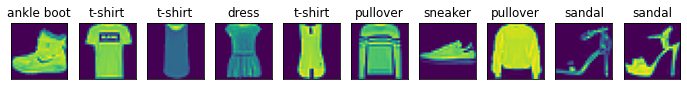

In [3]:
# training_data是一个包含60000元组数据的dataset类，可以用索引返回一个元组(X, y)
print(len(training_data))
feature, label = training_data[0]
print(feature.shape, label)

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

X, y = [], []
for i in range(10):
    X.append(training_data[i][0])
    y.append(training_data[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

In [4]:
batch_size = 64
num_workers = 8 # 多进程读取
# Create data loaders
# DataLoader will return a iterator
training_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print("Shape of X [Number, Color, Height, Width]: ", X.shape, X.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [Number, Color, Height, Width]:  torch.Size([64, 1, 28, 28]) torch.float32
Shape of y:  torch.Size([64]) torch.int64


## Creating Models

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device.".format(device))

Using cpu device.


In [6]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        # 构建一个[28*28, 512, 10]的神经网络
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimizing the Model Parameters
To train a model, we need a loss function and an optimizer.

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader): # 60000 // 64 = 938，共进行938个batch迭代
        X, y = X.to(device), y.to(device)

        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Back propagation
        optimizer.zero_grad() # 因为梯度是累加的，将梯度清零
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:  # 每训练100个batch的数据，显示一次损失值
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # 10000 数据集个数
    num_batches = len(dataloader) # 10000 / 64  迭代次数
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item() # 计算总损失值
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # 计算总共准确个数
    test_loss /= num_batches  # 求出平均损失值
    correct /= size  # 求出平均准确率
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
            
     
            

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n------------------------")
    train(training_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
------------------------
loss: 2.303026  [    0/60000]
loss: 2.303477  [ 6400/60000]
loss: 2.277834  [12800/60000]
loss: 2.273173  [19200/60000]
loss: 2.251075  [25600/60000]
loss: 2.241117  [32000/60000]
loss: 2.226358  [38400/60000]
loss: 2.209072  [44800/60000]
loss: 2.200544  [51200/60000]
loss: 2.183628  [57600/60000]
Test Error: 
 Accuracy: 37.8%, Avg loss: 2.168446 

Epoch 2
------------------------
loss: 2.174185  [    0/60000]
loss: 2.167192  [ 6400/60000]
loss: 2.132927  [12800/60000]
loss: 2.102296  [19200/60000]
loss: 2.064941  [25600/60000]
loss: 2.081500  [32000/60000]
loss: 2.014067  [38400/60000]
loss: 1.993570  [44800/60000]
loss: 1.965044  [51200/60000]
loss: 1.969133  [57600/60000]
Test Error: 
 Accuracy: 53.3%, Avg loss: 1.921062 

Epoch 3
------------------------
loss: 1.822640  [    0/60000]
loss: 1.900873  [ 6400/60000]
loss: 1.783774  [12800/60000]
loss: 1.782570  [19200/60000]
loss: 1.781944  [25600/60000]
loss: 1.807947  [32000/60000]
loss: 1.724945  [

## Saving Models

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth!")

Saved PyTorch Model State to model.pth!


## Loading Models

In [10]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f"Predicted: '{predicted}', Actual: '{actual}'")


Predicted: 'Ankle boot', Actual: 'Ankle boot'
